Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


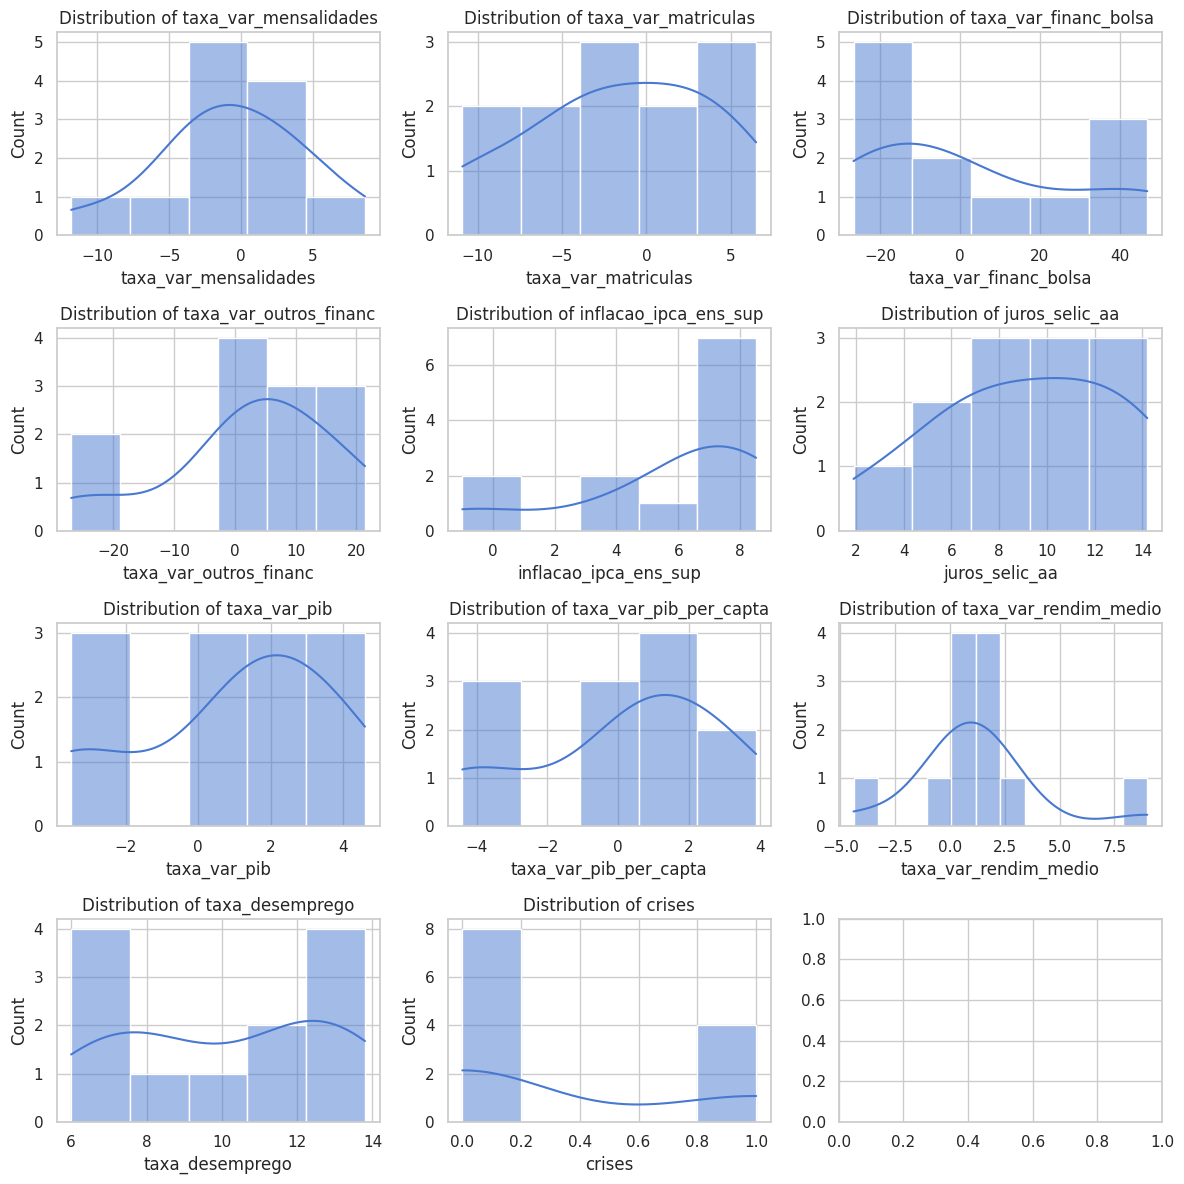

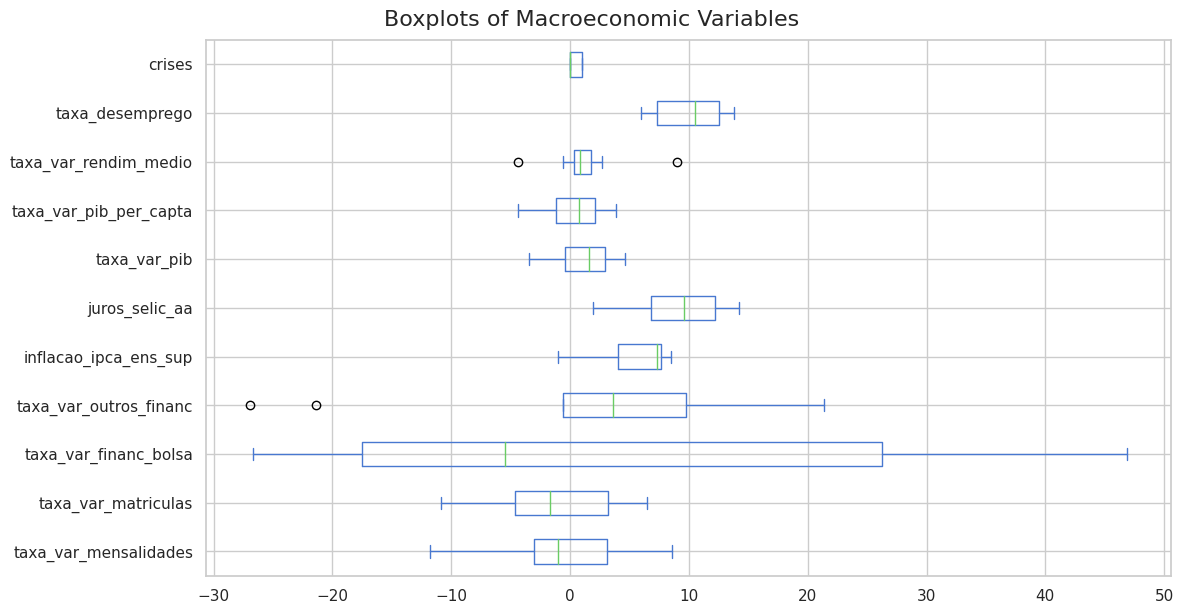

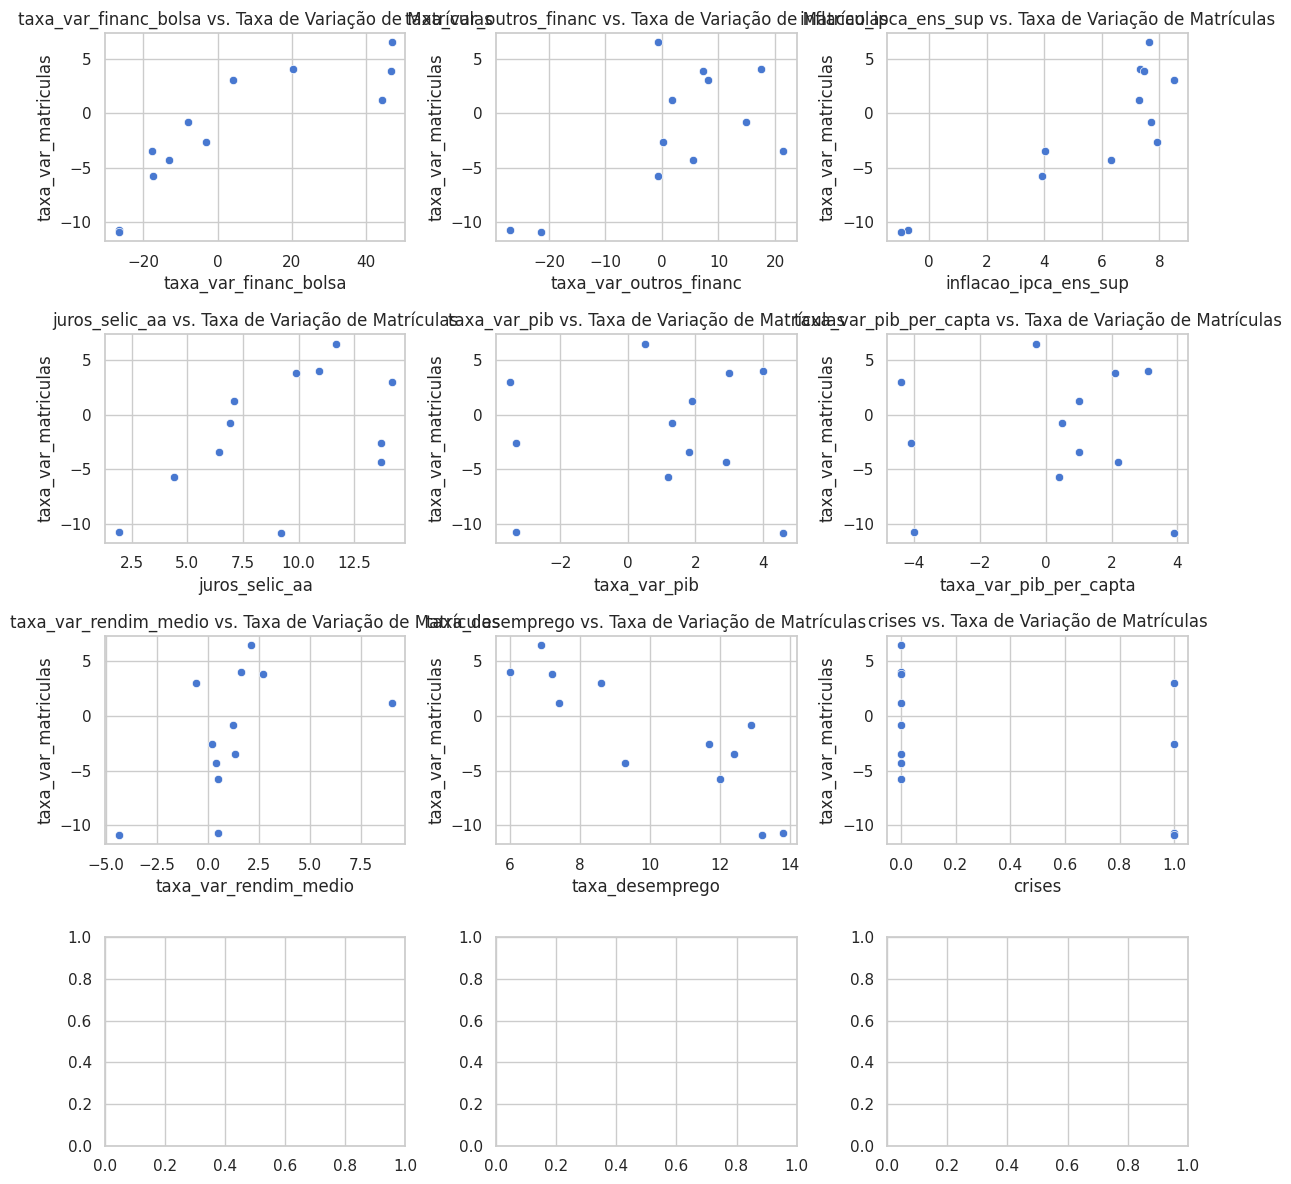

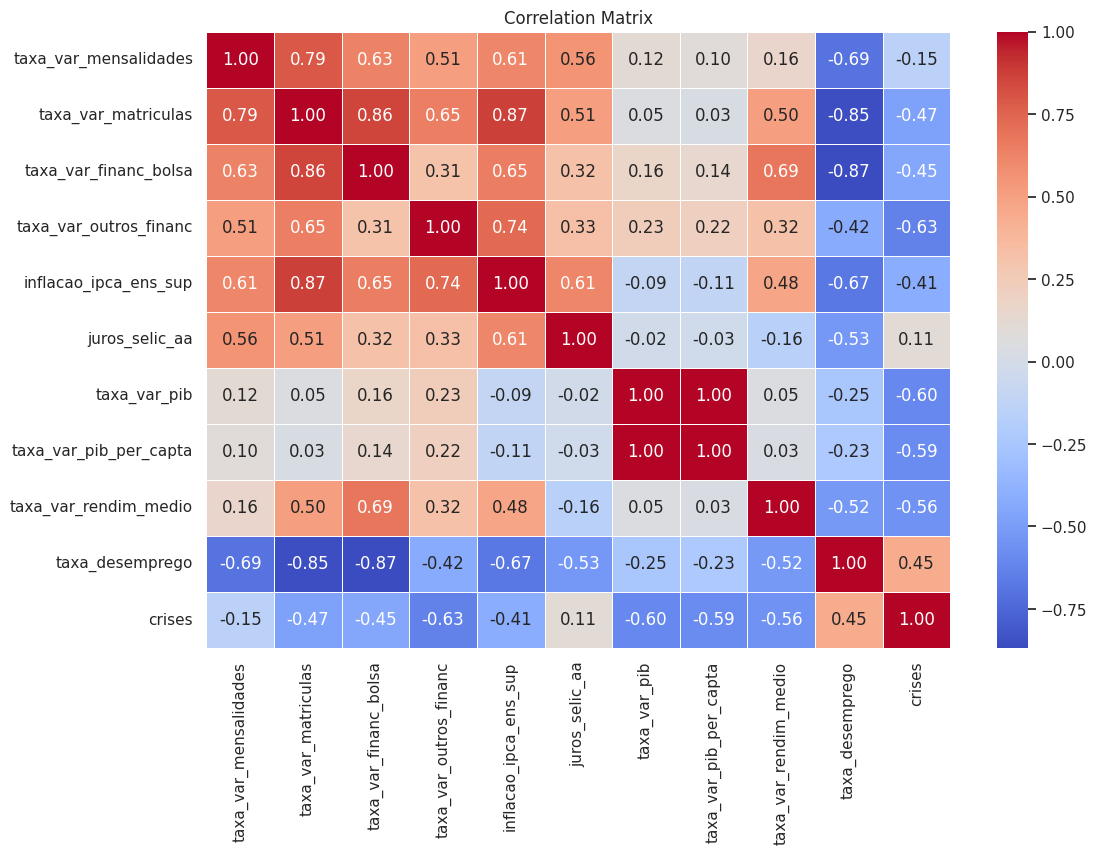

taxa_var_matriculas       1.000000
inflacao_ipca_ens_sup     0.871793
taxa_var_financ_bolsa     0.859079
taxa_var_mensalidades     0.789648
taxa_var_outros_financ    0.648608
juros_selic_aa            0.505869
taxa_var_rendim_medio     0.504780
taxa_var_pib              0.048216
taxa_var_pib_per_capta    0.025832
crises                   -0.473748
taxa_desemprego          -0.854356
Name: taxa_var_matriculas, dtype: float64
                   Feature           VIF
0                    const      1.000000
1    taxa_var_mensalidades      8.815892
2    taxa_var_financ_bolsa     12.021244
3   taxa_var_outros_financ     13.009283
4    inflacao_ipca_ens_sup     35.964531
5           juros_selic_aa     34.163693
6             taxa_var_pib  38209.017254
7   taxa_var_pib_per_capta  38923.863605
8    taxa_var_rendim_medio      5.306189
9          taxa_desemprego     16.761251
10                  crises     32.532200
MAE: 0.20918874770218335
                                 OLS Regression Results 

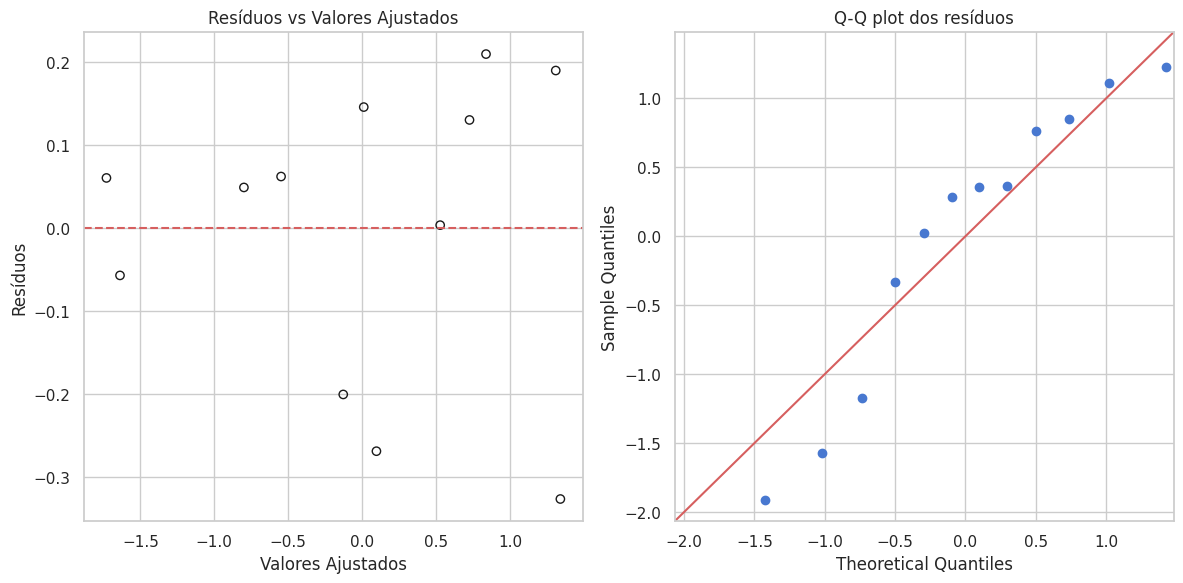

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan, acorr_breusch_godfrey
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import anderson, shapiro, kstest, boxcox, yeojohnson
from math import sqrt
import warnings
warnings.simplefilter('ignore')

# Google Colab Drive Mount
from google.colab import drive
drive.mount('/content/drive')

# Load Data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_conjuntura_v5.csv')
df.set_index('ano', inplace=True)
df['crises'].astype(bool)

# Exploratory Data Analysis (EDA)
df.head(12)
df.shape
df.describe()
df.isnull().sum()

# Visualization Settings
sns.set(style="whitegrid", palette="muted")

# Creating Subplots for Histograms
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
cols = df.columns[0:]
for i, col in enumerate(cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Boxplots for Outlier Detection
fig, ax = plt.subplots(figsize=(12, 6))
df.plot(kind='box', ax=ax, vert=False)
plt.tight_layout()
plt.suptitle('Boxplots of Macroeconomic Variables', fontsize=16, y=1.02)
plt.show()

# Scatter Plots for Predictor Variables
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
predictor_cols = df.columns[1:].drop("taxa_var_matriculas")  # Excluding dependent variable
for i, col in enumerate(predictor_cols):
    row = i // 3
    col_idx = i % 3
    sns.scatterplot(data=df, x=col, y="taxa_var_matriculas", ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} vs. Taxa de Variação de Matrículas')
plt.tight_layout()
plt.show()

# Correlation Matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()
print(correlation_matrix['taxa_var_matriculas'].sort_values(ascending=False))

# Data Preparation
scaler = StandardScaler()
# Checking and handling infinite or NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
scaler.fit(df)
data_standardized = scaler.transform(df)
data_standardized_df = pd.DataFrame(data_standardized, index=df.index, columns=df.columns)

# Setting Dependent and Independent Variables
y = data_standardized_df['taxa_var_matriculas']
X = data_standardized_df.drop(['taxa_var_matriculas'], axis=1)
X = sm.add_constant(X)

# Variance Inflation Factor (VIF) Calculation
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

# Backward Elimination for Variable Selection
selected_features = list(X.columns)
p_value_limit = 0.02
while True:
    model = sm.OLS(y, X[selected_features]).fit()
    p_values = model.pvalues
    max_p_value = max(p_values)
    max_p_value_feature = p_values.idxmax()
    if max_p_value > p_value_limit:
        selected_features.remove(max_p_value_feature)
    else:
        break

# Training and Test Set Split
X_final = X[selected_features]
X_final.replace([np.inf, -np.inf], np.nan, inplace=True)
X_final.dropna(inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.dropna(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Fit the Final Model with Training Data
model_train = sm.OLS(y_train, X_train).fit()
y_pred = model_train.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')
print(model_train.summary())

# Leave-One-Out Cross Validation (LOO)
loo = LeaveOneOut()
mae_scores = []
vif_data_list = []
for train_index, test_index in loo.split(X_final):
    X_train, X_test = X_final.iloc[train_index], X_final.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    loo_model = sm.OLS(y_train, X_train).fit()
    y_pred = loo_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
average_mae = np.mean(mae_scores)
print(f'Average MAE from LOO: {average_mae}\n')

# Regression Assumptions Tests
X_final_with_const = sm.add_constant(X_final)
model = sm.OLS(y, X_final_with_const).fit()
rainbow_stat, rainbow_p_value = linear_rainbow(model, frac=0.75)
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_stat, bp_p_value = bp_test[:2]
bg_test = acorr_breusch_godfrey(model, nlags=1)
bg_stat, bg_p_value = bg_test[:2]
resultado_anderson = anderson(model.resid, dist='norm')

# Newey-West Estimator Application
newey_west_model = model.get_robustcov_results(cov_type='HAC', maxlags=1)
print(newey_west_model.summary())

# Diagnostic Tests Results
print("Anderson-Darling Test:")
print("Test Statistic:", resultado_anderson.statistic)
print("Critical Values:", resultado_anderson.critical_values)
print("Significance Levels:", resultado_anderson.significance_level)
print()
print("Rainbow Statistic:", rainbow_stat, "p-value:", rainbow_p_value)
print("Breusch-Pagan Statistic:", bp_stat, "p-value:", bp_p_value)
print("Breusch-Godfrey Statistic:", bg_stat, "p-value:", bg_p_value)
print()

# VIF Data Printing
vif_data = pd.DataFrame({
    'Feature': X_final.columns,
    'VIF': [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]
})
print("VIF Data:")
print(vif_data)
print()

# Residuals Plots
plt.figure(figsize=(12, 6))
residuals = model.resid
fitted = model.fittedvalues
plt.subplot(1, 2, 1)
plt.scatter(fitted, residuals, edgecolors='k', facecolors='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados')
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, ax=plt.gca())
plt.title('Q-Q plot dos resíduos')
plt.tight_layout()
plt.show()
